7/28/2024\
Author: Michael Stoll\
\
This assignment is going to look a bit different from my previous submissions, because I run a Windows machine and autoML is incompatible with windows32. So most of it is going to be screenshots from my WSL environment instead. I will include actual lines of code, but I won't be running any of it since it obviously won't actually work. That bit is simply so that if you run an environment that is actually compatible, you can follow along at home.\
\
All that aside, I decided that the first important step was to run the code included with the assignment. This was the result:

In [ ]:
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml(data_id=40691, as_frame=True, return_X_y=True)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print("RF Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))

from autosklearn import AutoSklearnClassifier

automl = AutoSklearnClassifier(time_left_for_this_task=300)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("AutoML Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))


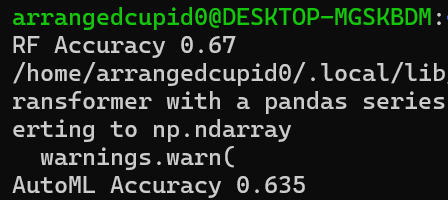

The bulk of the text that you see there is an error thrown because Python is concerned that there is a type conversion that may lose data. As all good computer scientists do, I fixed that error with this line:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Now it was time to begin some actual optimization. After I pulled up the documentation for AutoSklearnClassifier, the first thing that occurred to me was the lack of cross-validation. Obviously in the absence of cross-validation we have less confidence in the accuracy of our testing since taking only one sample deprives us of any sort of 'mean' value of accuracy, that much was made clear even as far back as the first time we attempted hyperparameter optimization. So, I augmented the AutoSklearnClassifier constructor to be this:

In [ ]:
automl = AutoSklearnClassifier(time_left_for_this_task=300, resampling_strategy='cv',
        resampling_strategy_arguments={"folds":10})

With the syntax of this classifier, all that this does is provide a 10-fold cross-validator to ensure that the score we see is closer to the average case performance than either the worst case or best case performance. This is just for my own sanity, and in no way provides a better model. I just want to ensure the presence of resampling. When I ran the program again, I got this:

In [ ]:
#again, I can't run these, but I'm going to put them in so that you can if you see fit
print("RF Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("AutoML Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))

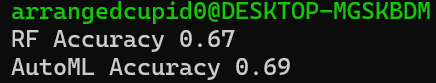

At this point, nothing substantial has changed about the classifier or how it runs, but at least now we know that our average AutoML accuracy is actually closer to 69%. This should help me better determine what things are truly helping at what things are not.\
\
After a bit of research, I determined that one of the biggest handicaps of autoML is overfitting. From the end of last semester, I remembered a presentation in which a student mentioned SMOTE, and when I looked over the documentation I understood why. Synthetic Minority Oversampling Technique (SMOTE) combats overfitting from imbalance by intentionally oversampling minority cases in the dataset, so it became clear to me that I needed to use this technique to properly represent my dataset. You'll see the imbalance that I am referring to in the data below.

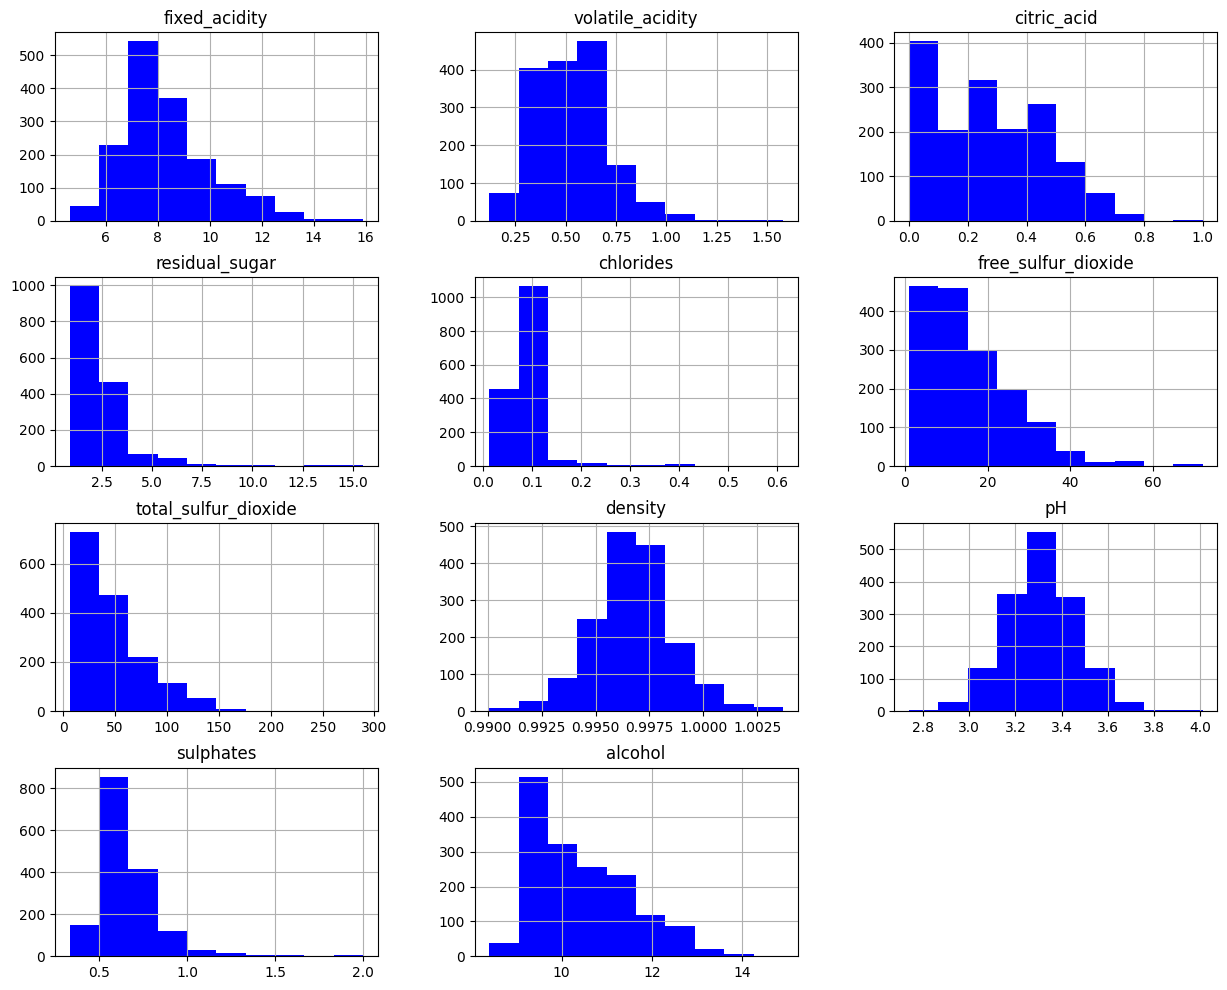

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
X.hist(figsize=(15,12), color='blue')
plt.show()

As you can see, there is clear skew in some features: some, like pH, are well balanced, but then there are others like residual_sugar that are very much not so. This means that that issue, imbalance, is a distinct issue in this particular dataset. So I applied SMOTE and re-split the data. Below is what I did to the code, and after is how that impacted first the dataset and then the final result.

In [ ]:
from imblearn.over_sampling import SMOTE

smoteX, smoteY = SMOTE(random_state=307).fit_resample(X, y)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(smoteX, smoteY, random_state=42)
automl.fit(X_train, y_train)

y_hat = automl.predict(X_test)
print("AutoML Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
smoteX.hist(figsize=(15,12), color='blue')
plt.title("Dataset after applying SMOTE")
plt.show()

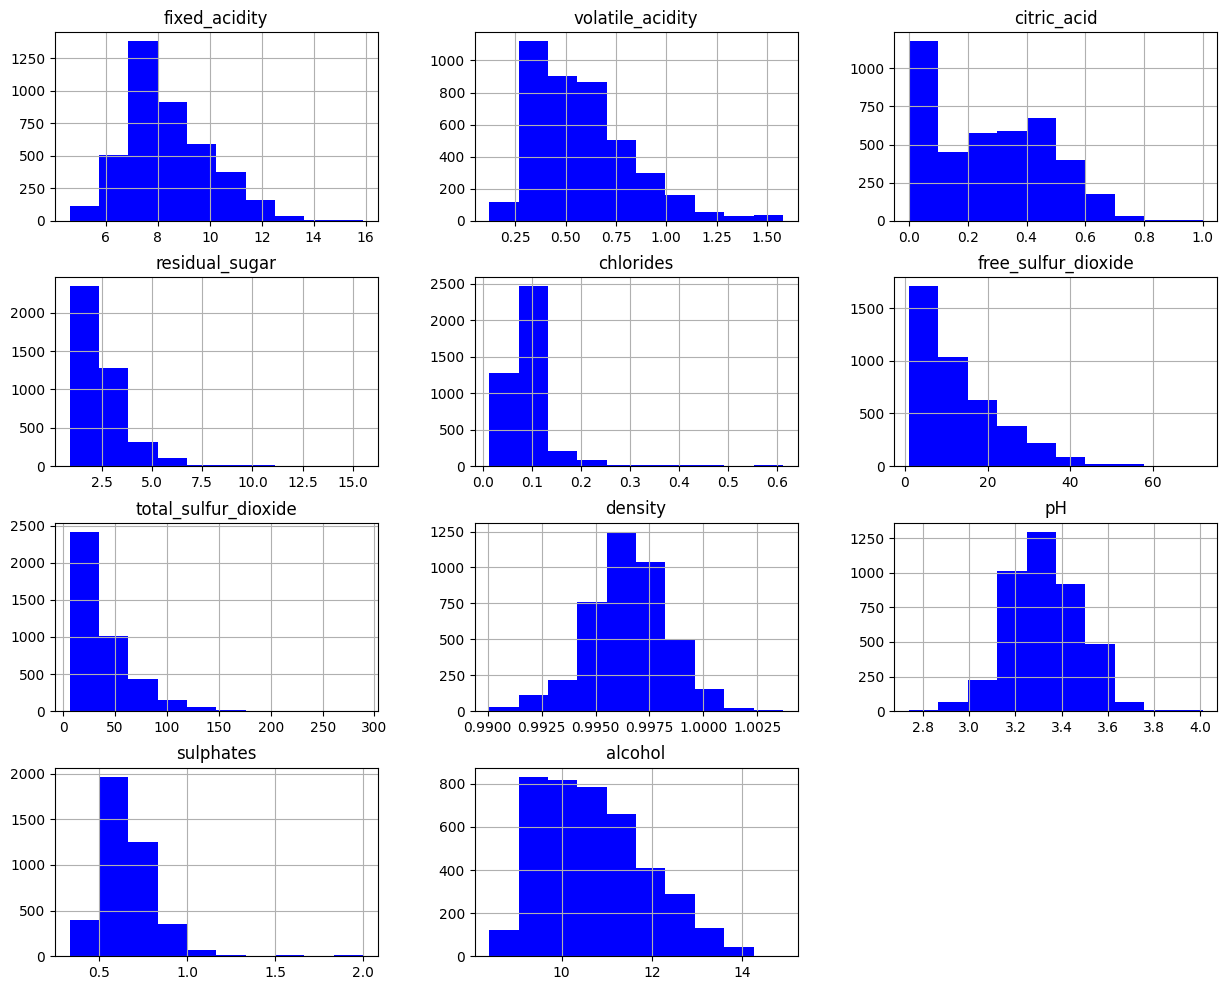

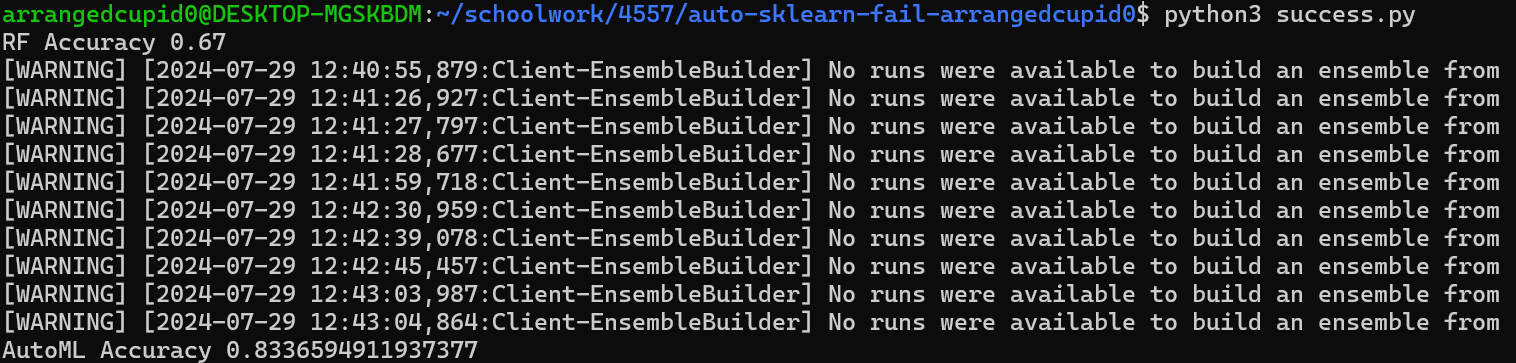

There are obviously a lot of warnings raised. I did research to try and determine what was causing these warnings, but ultimately I came up empty handed because apparently there is no documentation surrounding it. My best guess is that some of the iterations that were run fell into some edge-case category that resulted in no runs being available for the creation of the ensemble (which is the different classifiers and such that AutoML tries to narrow down to a better accuracy.)\
\
Regardless of that error and my incompetence in fixing it, there is a clear improvement in this step, which proves that overfitting was a root issue for AutoSklearnClassifier. So, to answer the questions posed by the original prompt:\
\
Auto-Sklearn overfits to imbalanced data, which results in bad performance on this dataset because this dataset is imbalanced.\
To fix it, all that you have to do is balance the data.